# Spectrum Sensing Data Set Generation

## Import Packages

In [280]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import colors

## Configure Data Set Parameters

In [281]:
# Random seed
seed = 0 
np.random.seed(seed)

# Number of Frames (time steps)
nframes = 6102

#Kian's code choose the first subcarrier
selectedSubcarrier = 0 

# Number of data subcarriers
numSubcarriers = 1 

# Number of OFDM symbols
numSym = 1 

# Number of Rx and Tx antennas
numRxAnt = numTxAnt = 1

# Signal to Noise Ratio in dB
# SNRdb = 0
# SNRdb = -5
# SNRdb = -10
# SNRdb = -20
# SNRdb = -30
# SNRdb = 20
# SNRdb = 50
# SNRdb = -1
SNRdb = -10
# SNRdb = -0.1


# Signal to Noise Ratio (Linear)
SNRlin = 10**(SNRdb/10)

In [282]:
10**(-10/10)

0.1

## Load Aachen University Spectrum Occupancy Measurements Sensing Data

[RWTH Aachen University Static Spectrum Occupancy Measurement Campaign](https://download.mobnets.rwth-aachen.de)

[Evaluation of Spectrum Occupancy in Indoor and Outdoor Scenario in the Context of Cognitive Radio](https://www.inets.rwth-aachen.de/fileadmin/PublicationPdfs/2007/SpectOcc.pdf)

In [283]:
# load spectrum occupancy data, each matrix contains 2034 OFDM frames for the 40 subcarriers
label23 = scipy.io.loadmat('aachen_spectrum_data/label23.mat')
label24 = scipy.io.loadmat('aachen_spectrum_data/label24.mat')
label25 = scipy.io.loadmat('aachen_spectrum_data/label25.mat')

# concatenate spectrum occupancy data loaded labels
labels = np.vstack([label23['label'], label24['label'], label25['label']])
labels = labels[:,selectedSubcarrier:selectedSubcarrier+1]

## Generate Random Data to Be Transmitted

In [284]:
# generate an array of symbols in range [0,1,2,3] for: nframes (time steps) (6102), numSym symbols (1), numTxAnt (1)
data = np.random.randint(0, 4, [nframes, numSym, numTxAnt])

## Perform QPSK Modulation on the Random Data

In [285]:
# qpsk mappings
mapping_table_qpsk = {
    0:  0.7071 + 0.7071j,
    1: -0.7071 + 0.7071j,
    2:  0.7071 - 0.7071j,
    3: -0.7071 - 0.7071j,
}

# mapping to QPSK symbols
modData = np.vectorize(mapping_table_qpsk.get)(data) 

## Generate Spectrum Sensing Data Set Using Modulated Data

In [286]:
# array of received data
received = []

# dataSize = number of subcarriers (1)
dataSize = labels.shape[1]

# number of time steps on each subcarrier
# for each frame (time step)
for k in range(nframes):

  # range(0,1)
  # range size = 1
  # [k,k+1]
  indData = range(k*dataSize, (k+1)*dataSize)

  # spectrum occupancy at the current frame for each subcarrier
  onandoff = labels[k,:]

  # modData.shape = (6102, 1, 1)
  # nframes (time steps) (6102), numSubcarriers subcarriers (1), numSym symbols (1), numTxAnt (1)
  data1 = modData[k:k+1,:,:].copy()

  # if subcarrier is busy (0), clear the transmitted symbol
  data1[onandoff==0,:,:] = 0

  # add the data of the selected subcarrier to the received array
  # selecting the symbols from each of the six antennas for the chosen subcarrier
  received.append(data1[selectedSubcarrier,:].reshape(-1)) #Choose only the first subcarrier from the 40
  
received = np.array(received)

## Add Noise to Received Symbols

In [287]:
# create np array with shape of received (6102 x 1)
receivedSignal = np.zeros_like(received)

# for each frame (time step)
for i in range(nframes):

  # calculate channel gain
  # np.random.randn(numTxAnt, numRxAnt) = dimensions of returned array = 1x1
  # chGain = ( rand_num + j * rand_num ) / sqrt(0.1)
  # chGain = (np.random.randn(numTxAnt, numRxAnt) + 1j*np.random.randn(numTxAnt, numRxAnt)) / np.sqrt(.1) # Random 2x2 channel
  chGain = (np.random.randn(numTxAnt, numRxAnt) + 1j*np.random.randn(numTxAnt, numRxAnt)) / np.sqrt(.1) # Random 2x2 channel

  # channel noise 1x1
  # channel noise only affects the real part
  nn = np.random.randn(1, numRxAnt) + 0j

  # multiply SNR received signal times channel gain
  # higher SNRlin == higher signal strength (signal higher than noise)
  # SNRlin = 10**(SNRdb/10)
  # if SNRdb is set high, SNRlin will be low and decrease the signal strength
  ss = np.sqrt(SNRlin) * received[i,:] * chGain
  # ss = np.sqrt(SNRlin) * np.dot(received[i,:], chGain)

  # add signal strength and noise
  receivedSignal[i,:] = ss + nn

In [288]:
receivedSignal.shape

(6102, 1)

## Visualize Data Before and After Noise

### Constellation Plots

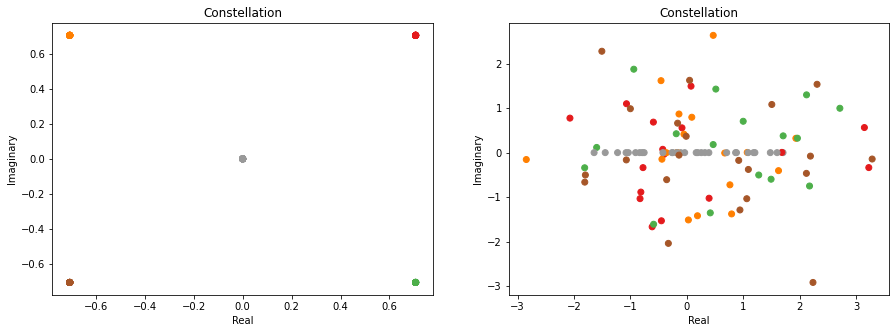

In [289]:
### clean samples ###
i = np.real(received[:,0])
q = np.imag(received[:,0])
symbol = np.zeros(6102)
for n in range(6102):
    if i[n] > 0 and q[n] > 0:
        symbol[n] = 0
    elif i[n] > 0 and q[n] < 0:
        symbol[n] = 1
    elif i[n] < 0 and q[n] > 0:
        symbol[n] = 2
    elif i[n] < 0 and q[n] < 0:
        symbol[n] = 3
    else:
        symbol[n] = 4
        
SAMPLES = 100

fig, ax = plt.subplots(1,2)
fig.figure.set_size_inches(15,5)

ax[0].scatter(i[:SAMPLES],q[:SAMPLES],c=symbol[:SAMPLES], cmap='Set1')
ax[0].set_xlabel("Real")
ax[0].set_ylabel("Imaginary")
ax[0].set_title("Constellation")

### samples with noise ###

i = np.real(receivedSignal[:,0])
q = np.imag(receivedSignal[:,0])
        
ax[1].scatter(i[:SAMPLES],q[:SAMPLES],c=symbol[:SAMPLES], cmap='Set1')
ax[1].set_xlabel("Real")
ax[1].set_ylabel("Imaginary")
ax[1].set_title("Constellation")

plt.show()

### Energy Plots

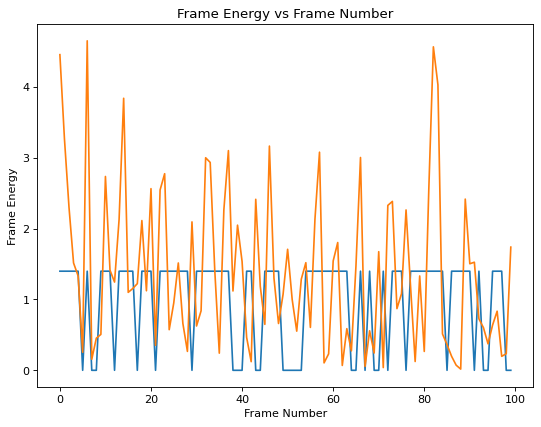

In [290]:
energy_before = np.sqrt(np.square(np.real(received[:,0])) + np.square(np.real(received[:,0])))
energy_after = np.sqrt(np.square(np.real(receivedSignal[:,0])) + np.square(np.real(receivedSignal[:,0])))

SAMPLES = 100

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(energy_before[:SAMPLES] * np.mean(energy_after[:SAMPLES]))
plt.plot(energy_after[:SAMPLES])

plt.xlabel("Frame Number")
plt.ylabel("Frame Energy")
plt.title("Frame Energy vs Frame Number")
plt.show()

## Save Spectrum Occupancy Data Set to a File

In [291]:
# record actual spectrum occupancy measure
target = labels[:nframes, selectedSubcarrier]

# format filename
# filename = './spectrum_data/spectrum_data_{}db.csv'.format(SNRdb)
filename = './spectrum_data/spectrum_data_{}db_{}ant.csv'.format(SNRdb,numRxAnt)

# reshape transmitted data matrix
i_data = np.real(received).reshape(nframes,1)
q_data = np.imag(received).reshape(nframes,1)

# reshape received data matrix
i_data_received = np.real(receivedSignal).reshape(nframes,1)
q_data_received = np.imag(receivedSignal).reshape(nframes,1)

# store transmitted and received data
combined_data = np.concatenate([i_data,q_data,i_data_received,q_data_received,target.reshape(nframes,1)],axis=1)

# save file
np.savetxt(filename, combined_data, delimiter=",")

In [292]:
received[:,0].shape

(6102,)

In [293]:
target.shape

(6102,)

In [294]:
# MIMO Version
# record actual spectrum occupancy measure
target = labels[:nframes, selectedSubcarrier]

# format filename
filename = './spectrum_data/mimo/spectrum_data_{}db_{}ant.csv'.format(SNRdb,numRxAnt)

# ADC_MAX_SIGNED = 2**11

# reshape transmitted data matrix
for i in range(numRxAnt):
    # i_data = np.real(received[:][0]).reshape(nframes,1)
    # q_data = np.imag(received[:][0).reshape(nframes,1)
    # i_data_out = np.real(received[:][0]).reshape(nframes,1)
    receivedSignal[:,i].astype("complex64").tofile(f"./spectrum_data/mimo/iq_data_ant_{i}.bin")
    # i_data_list.append(((i_data / np.max(i_data)) * (ADC_MAX_SIGNED)).astype(np.short))
    # q_data_list.append(np.imag(received[:][0]).reshape(nframes,1))

target.astype("float32").tofile("./spectrum_data/mimo/output.bin")

# reshape received data matrix
# i_data_received = np.real(receivedSignal).reshape(nframes,1)
# q_data_received = np.imag(receivedSignal).reshape(nframes,1)

# store transmitted and received data
combined_data = np.concatenate([i_data,q_data,i_data_received,q_data_received,target.reshape(nframes,1)],axis=1)

# save file
np.savetxt(filename, combined_data, delimiter=",")

## Save Spectrum Occupancy Data using an ADC Scale

In [295]:
# max ADC output for signed/unsigned number
ADC_MAX_SIGNED = 2**11

# normalize, convert to ADC output representation
i_data = ((i_data_received / np.max(i_data_received)) * (ADC_MAX_SIGNED)).astype(np.short)
q_data = ((q_data_received / np.max(q_data_received)) * (ADC_MAX_SIGNED)).astype(np.short)
# i_data = ((i_data / np.max(i_data)) * (ADC_MAX_SIGNED)).astype(np.short)
# q_data = ((q_data / np.max(q_data)) * (ADC_MAX_SIGNED)).astype(np.short)

fh = open(f"./spectrum_data/spectrum_data_adc_{SNRdb}db.csv","w")
for i in range(nframes):
    fh.write(str(i_data[i][0]) + "," + str(q_data[i][0]) + "," + str(target[i].astype(int)) + "\n")
fh.close()

## Save Spectrum Occupancy Data in Intel HEX File Format for Hardware

In [296]:
# write input data hex file (all data)
fh = open(f"./spectrum_data/iq_data_rom_{SNRdb}db.hex","w")
addr = 0x0000
for i in range(i_data.size):
    fh.write(':04{:04x}00{:04x}{:04x}FF\n'.format(addr,i_data[i][0] & 0xffff,q_data[i][0] & 0xffff))
    addr += 1
fh.write(':00000001FF')
fh.close()